In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models , layers
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
'PlantVillage',
shuffle = True,
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

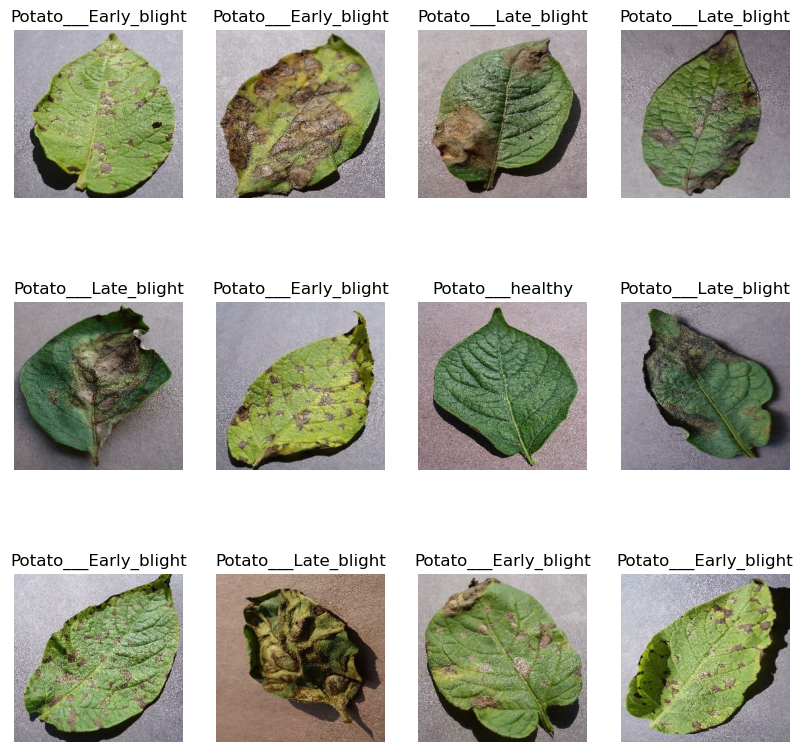

In [6]:
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    

80% training
10% vadilation 10% test

In [7]:
len(dataset)*0.8

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [11]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [12]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [13]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax'),
    
])

model.build(input_shape = input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/20


54/54 [==============================] - 139s 2s/step - loss: 0.9363 - accuracy: 0.4740 - val_loss: 0.9102 - val_accuracy: 0.4219
Epoch 2/20
54/54 [==============================] - 139s 3s/step - loss: 0.7242 - accuracy: 0.6308 - val_loss: 0.6006 - val_accuracy: 0.7292
Epoch 3/20
54/54 [==============================] - 135s 2s/step - loss: 0.4328 - accuracy: 0.8108 - val_loss: 0.3267 - val_accuracy: 0.8750
Epoch 4/20
54/54 [==============================] - 128s 2s/step - loss: 0.3124 - accuracy: 0.8669 - val_loss: 0.3243 - val_accuracy: 0.8542
Epoch 5/20
54/54 [==============================] - 135s 2s/step - loss: 0.2240 - accuracy: 0.9097 - val_loss: 0.3000 - val_accuracy: 0.9219
Epoch 6/20
54/54 [==============================] - 127s 2s/step - loss: 0.2104 - accuracy: 0.9225 - val_loss: 0.1782 - val_accuracy: 0.9375
Epoch 7/20
54/54 [==============================] - 135s 2s/step - loss: 0.1916 - accuracy: 0.9311 - val_loss: 0.1312 - val_accuracy: 0.9531
Epoch 8/20


In [23]:
scores = model.evaluate(test_ds) 

8/8 [==============================] - 13s 543ms/step - loss: 0.0589 - accuracy: 0.9727


In [24]:
scores


[0.05894981324672699, 0.97265625]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
len(history.history['accuracy'])

20

In [32]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

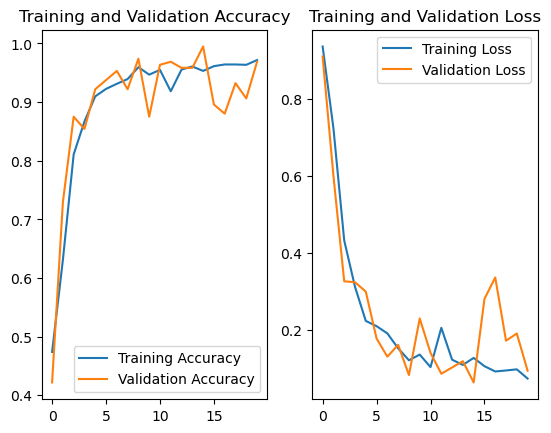

In [44]:

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

First Image to Predict
Actual Label Potato___Early_blight
1/1 [==============================] - 0s 497ms/step
Predicted Label Potato___Early_blight


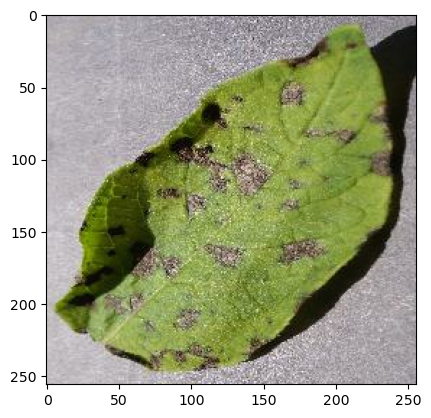

In [48]:
for image_batch,label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print('First Image to Predict')
    plt.imshow(first_image)
    print('Actual Label',class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])
    

In [84]:
def predict(model,img):
    img_array = tf.keras.utils.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class,confidence


1/1 [==============================] - 0s 65ms/step


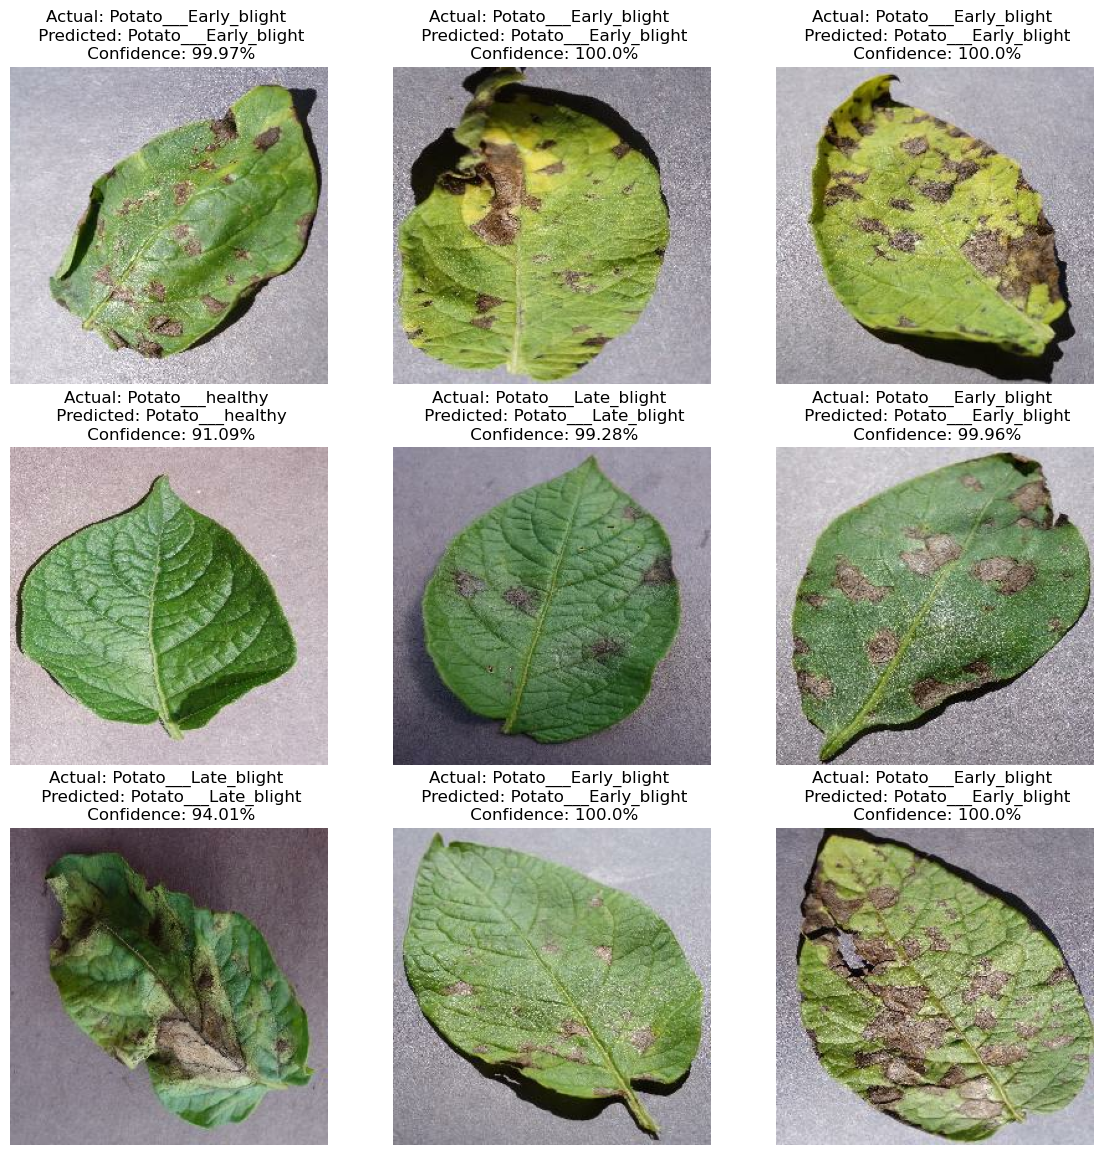

In [85]:
plt.figure(figsize = (14,14))

for image,label in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        
        predicted_class , confidence = predict(model,image[i])
        actual_class = class_names[label[i]]

        plt.title(f'Actual: {actual_class} \n Predicted: {predicted_class}\n Confidence: {confidence}%')
        plt.axis('off')

In [88]:
model_version = 1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
